In [462]:
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

Garbage collector: collected 23 objects.


In [181]:
del customer_grouped_1,customer_grouped_2,customer_grouped_3, df3, df2, customer_grouped

In [460]:
%%time
# cell for memory management
# run it to see the memory which each variable is using and delete them
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

         customer_group_merged: 365.1 MiB
                          _383: 162.4 MiB
                          _399: 162.4 MiB
                          _382: 162.4 MiB
                          _398: 162.4 MiB
                          _381: 157.2 MiB
                          _290:  5.2 MiB
                cluster_labels:  5.2 MiB
                          _122:  5.2 MiB
                          _192:  5.2 MiB
Wall time: 1.78 s


# Finding Customer Segements

This project is inspired by H&M Transactions Data.

Customer segmentation is important in understanding and discovering new opportunities to improve the business metrics.

The dataset was originally provided by H&M.(put link).
I aggregated the dataset to represent the customers' shopping pattern.
The features of the new dataset are the number of items that each customer bought in each category.
I identified 9 clusters using K-means clustering.
For more details about the process, please refer to the clustering notebook in the repo.

Now let's take a look at the clusters in detail.

## 0. Load data and libraries

In [44]:
from pathlib import Path
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

In [388]:
# loda data
data_path = Path("../data")
articles = dd.read_csv(data_path /"articles.csv")
customers = dd.read_csv(data_path /"customers.csv")
transactions = dd.read_csv(data_path /"transactions_train.csv")

# change dtype of some columns
transactions['t_dat'] = transactions['t_dat'].astype('datetime64') # to use it as datetime
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype('int8') # to reduce memory

# merge transactions and articles data
## select only necessary columns
transactions_merged = dd.merge(transactions, articles[['article_id', 'index_group_name', 'index_name', 'section_name']], how='left', on='article_id')

In [87]:
%%time
# groupby transactions_merged to make train df for k-means clustering
customer_grouped_1 = transactions_merged.groupby(['customer_id','index_group_name']).sales_channel_id.count().compute()
customer_grouped_1 = customer_grouped_1.unstack(-1)
customer_grouped_2 = transactions_merged[transactions_merged['index_group_name']=='Ladieswear'].groupby(['customer_id','index_name']).sales_channel_id.count().compute() # divide Ladieswear index group since it's too big
customer_grouped_2 = customer_grouped_2.unstack(-1)
customer_grouped_3 = transactions_merged[transactions_merged['index_name']=='Ladieswear'].groupby(['customer_id','section_name']).sales_channel_id.count().compute() # divide Ladieswear index since it's too big
customer_grouped_3 = customer_grouped_3.unstack(-1)

# merge grouped customer df
customer_group_merged  = customer_grouped_1.drop(columns='Ladieswear').join(customer_grouped_2.drop(columns='Ladieswear'), how='outer',rsuffix = 'index').join(customer_grouped_3, how='outer',rsuffix = 'section')
del customer_grouped_1,customer_grouped_2,customer_grouped_3
customer_group_merged = customer_group_merged.fillna(0)
customer_group_merged['total'] = customer_group_merged.sum(axis=1)

# calculate the fraction of each category
for c in customer_group_merged.columns:
    customer_group_merged[c] /= customer_group_merged['total']
customer_group_merged = customer_group_merged.drop(columns=['total'])

Wall time: 5min 28s


In [180]:
# save merged df for later
## customer_group_merged.to_parquet(data_path /"customer_group_merged.parquet", engine='fastparquet')

## K-Means Clustering with 9 Clusters

In [246]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Initialize the clusterer with n_clusters value
n_clusters = 9
clusterer = KMeans(n_clusters=n_clusters, init='k-means++', random_state=47) # set seed for reproducibility
cluster_labels = clusterer.fit_predict(customer_group_merged)

In [211]:
# save cluster_label to reuse in a webapp
## np.save("../streamlit_app/cluster_labels.npy", cluster_labels)

### Plot a 3D Scatter Plot

In [202]:
# perform PCA for a 3D plot
pca = PCA(n_components=3)
df_pca = pca.fit_transform(customer_group_merged)
# sample rows for a scatter plot
number_of_samples = 10000
np.random.seed(47)
sample_indices = np.random.choice(len(df_pca), number_of_samples, replace=False)
df_pca_samples = df_pca[sample_indices]
cluster_labels_samples = cluster_labels[sample_indices]

In [210]:
# save data to reuse in a webapp
# np.save("../streamlit_app/df_pca_samples.npy", df_pca_samples)
# np.save("../streamlit_app/cluster_labels_samples.npy", cluster_labels_samples)

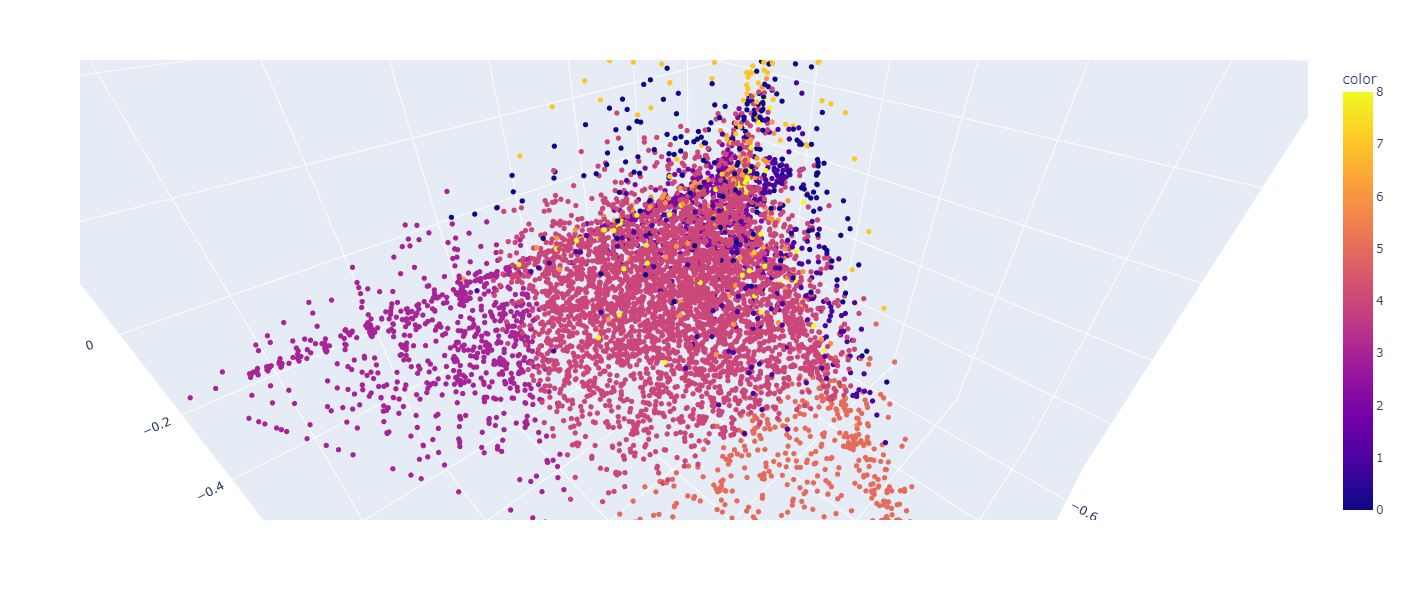

In [203]:
import plotly.express as px
fig = px.scatter_3d(df_pca_sample, x= df_pca_sample[:,0], y= df_pca_sample[:,1],z = df_pca_sample[:,2],
                  color=cluster_labels_samples, labels={'x':'Feature 1', 'y':'Feature 2','z':'Feature 3'},width = 800, height=600 )
fig.update_traces(marker_size=3)
fig.show()

**The PCA are performed to plot the points. Though the variance has been decreased due to the PCA, we see that the customers are well clustered.**

### Distribution of Each Cluster

In [130]:
bins, counts = np.unique(cluster_labels, return_counts=True)

In [129]:
np.histogram(cluster_labels)

(array([ 60971,  61368, 183424, 207377,      0, 595934, 139209,  36897,
         49951,  27150], dtype=int64),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]))

In [484]:
counts = pd.Series(cluster_labels).value_counts().sort_values(ascending=False)
counts = counts.rename('Number of Customers')
bins = np.array(counts.index)

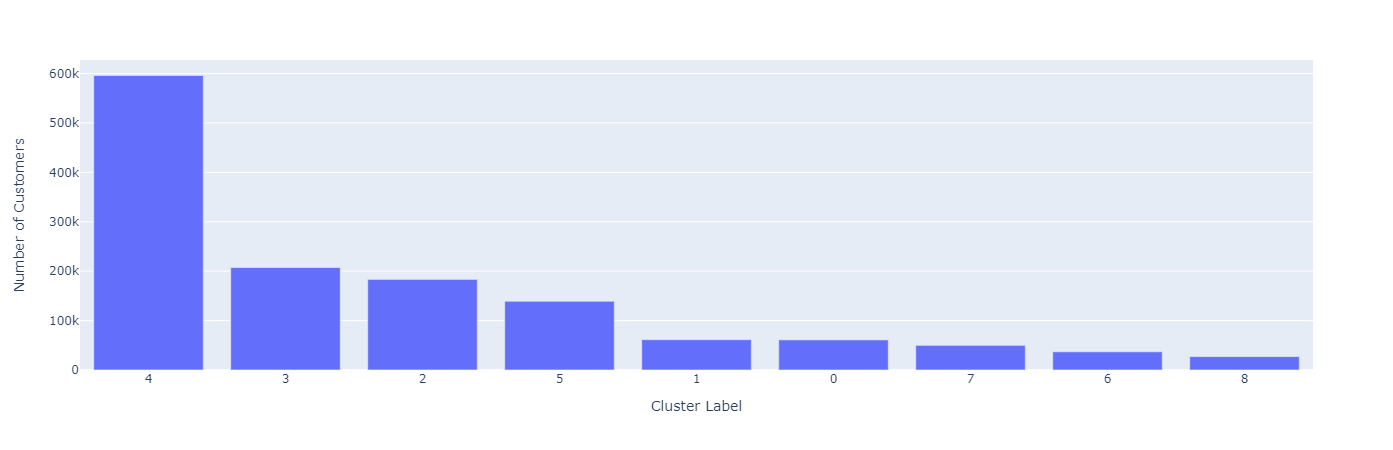

In [485]:
fig = px.bar(x=bins, y=counts, labels={'x':'Cluster Label', 'y':'Number of Customers'}, width = 600, height=450)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        showticklabels =  True,
        type = 'category'
    )
)
fig.show()

**The majority of customers belong to 'cluster 4'. Let's see each cluster's characteristics to understand them**

## Characteristics of Each Cluster

In [547]:
# get the center of each cluster
centers = pd.DataFrame(clusterer.cluster_centers_).T
centers.columns = centers.columns.astype('str')
centers['r'] = customer_group_merged.columns

In [548]:
# save the df for the webapp
centers.to_csv("../streamlit_app/centers.csv",index=False)

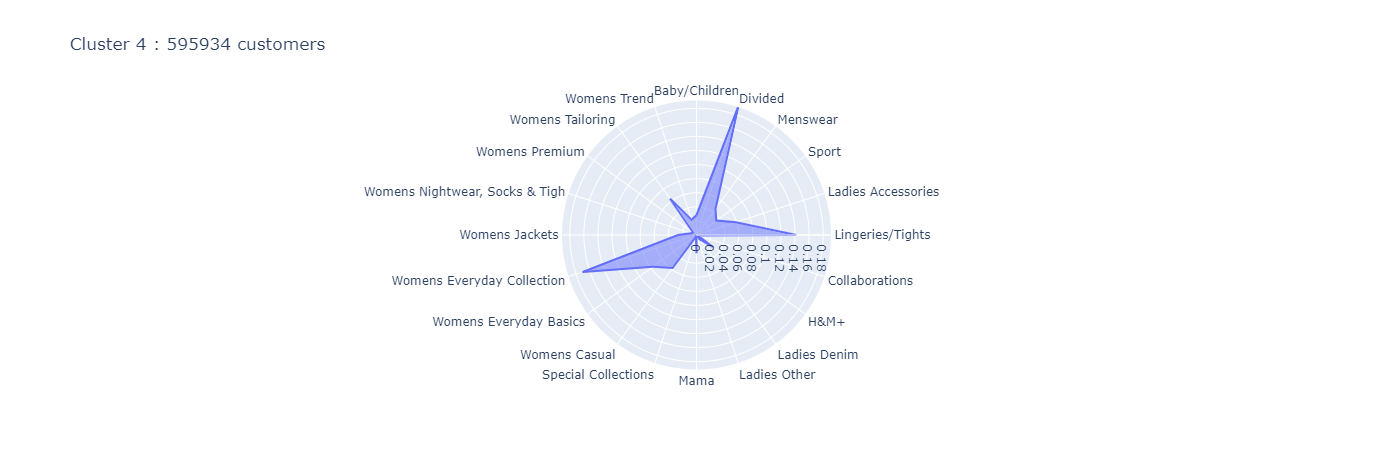

KeyError: "None of [Index(['4'], dtype='object')] are in the [columns]"

In [546]:
cluster_order = pd.Series(cluster_labels).value_counts().iteritems()

# show the radar plot for each cluster in the order of the number of customers
for i, number in cluster_order:
    fig = px.line_polar(centers, r=i, theta='r', line_close=True,title=f'Cluster {i} : {number} customers',width = 600, height=450)
    fig.update_traces(fill='toself')
    fig.show()
    display((centers[[str(i)]]*100).applymap('{:,.2f}%'.format).T.rename(columns=centers['r']))
    print(i, number)

In [378]:
customer_group_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1362281 entries, 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657 to ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241
Data columns (total 20 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Baby/Children                   1362281 non-null  float64
 1   Divided                         1362281 non-null  float64
 2   Menswear                        1362281 non-null  float64
 3   Sport                           1362281 non-null  float64
 4   Ladies Accessories              1362281 non-null  float64
 5   Lingeries/Tights                1362281 non-null  float64
 6   Collaborations                  1362281 non-null  float64
 7   H&M+                            1362281 non-null  float64
 8   Ladies Denim                    1362281 non-null  float64
 9   Ladies Other                    1362281 non-null  float64
 10  Mama       

```
Index Group : Ladieswear, Divided, Menswear, ...
└───Index : Ladieswear, Lingeries/Tights, Divided, Menswear, ...
│   └───Section : Womens Everyday Collection, Womens Langerie, Divided Collection, Men Underwear, ...
│   │   └───Product Type: Trousers, Bra, T-shirt
│   │   │   └───Product: Jade HW Skinny Denim TRS,
│   │   │   │   └───Article:
```

## Average Spending and Visits(Orders) of Customers in Each Cluster

#### Spending

In [475]:
# make df with customer id and cluster label
customers_id_labels = dd.from_pandas(pd.DataFrame(cluster_labels,index=customer_group_merged.index, columns=['cluster']).reset_index(),npartitions=3)
# 
customer_mean_spending = transactions.groupby('customer_id').price.sum().reset_index()
cluster_mean_spending = dd.merge(customer_mean_spending, customers_id_labels, how='left', on='customer_id')
cluster_mean_spending = cluster_mean_spending.groupby('cluster').price.mean().compute()

In [437]:
# save data to reuse in a webapp
# np.save("../streamlit_app/cluster_mean_spending.npy", cluster_mean_spending)

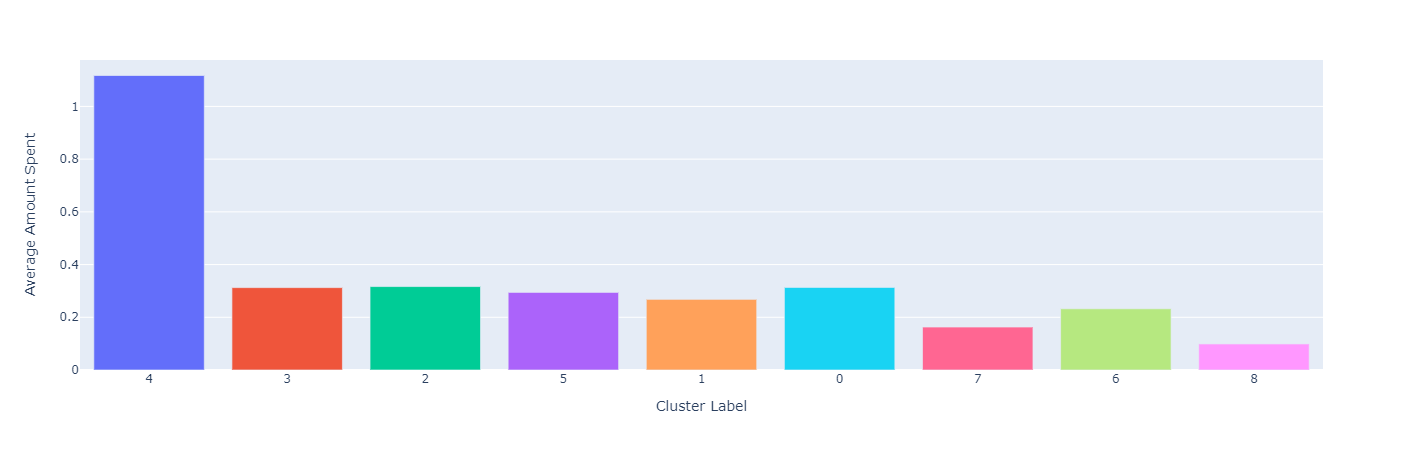

In [514]:
# Barchart
counts = [cluster_mean_spending[n] for n in bins]

# bins, same order of bins as previous histogram will be used for comparison
fig = px.bar(x=bins, y=counts, labels={'x':'Cluster Label', 'y':'Average Amount Spent'}, width = 600, height=450,color = px.colors.qualitative.Plotly[:9])
fig.update_layout(xaxis = dict(tickmode = 'array',
                                showticklabels =  True,
                                type = 'category'
                              ),
                  showlegend=False
                 )
fig.show()

The price was converted to arbitrary unit since it is sensitive information

#### Number of orders placed

In [471]:
# customer_id, count.t_dat
customer_mean_orders = transactions.groupby('customer_id').t_dat.count().reset_index()
# cluster, mean of count.t_dat
cluster_mean_orders = dd.merge(customer_mean_orders, customers_id_labels, how='left', on='customer_id')
cluster_mean_orders = cluster_mean_orders.groupby('cluster').t_dat.mean().compute()

In [476]:
# save data to reuse in a webapp
# np.save("../streamlit_app/cluster_mean_orders.npy", cluster_mean_orders)

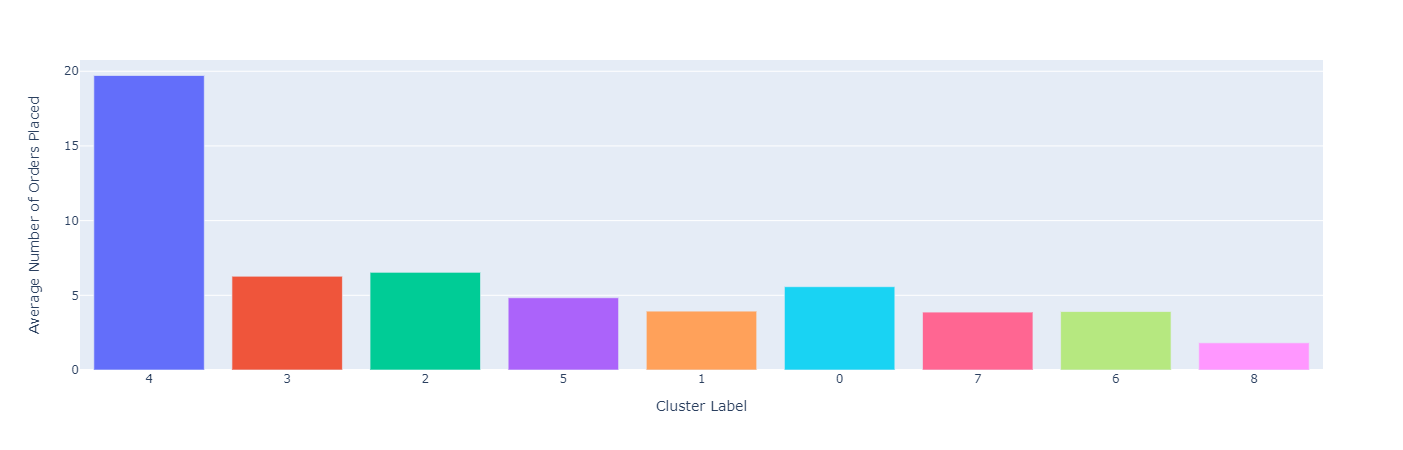

In [512]:
# Barchart
counts = np.array([cluster_mean_orders[n] for n in bins]) / 2 # orders per year
# same order of bins as previous histogram will be used for comparison
fig = px.bar(x=bins, y=counts, labels={'x':'Cluster Label', 'y':'Average Number of Orders Placed'}, width = 600, height=450,color = px.colors.qualitative.Plotly[:9])
fig.update_layout(xaxis = dict(tickmode = 'array',
                               showticklabels =  True,
                               type = 'category'
                               ),
                  showlegend=False
                 )
fig.show()

In [525]:
pd.DataFrame([[0,'asdf \n zxcv'],[2,3]]).loc[0,1]

'asdf \n zxcv'

Description for the cluster 4 \
From their shopping pattern is more distributed than other clusters. They buy mostly from Divided Womens Everyday Collection, Langeries/Tights. They place orders more frequent than other clusters and thus spend more too. They are loyal customer to the brand since they visit often and spend the most. 


In [539]:
np.unique(cluster_labels, return_counts=True)[1] / len(cluster_labels) * 100

array([ 4.47565517,  4.50479747, 13.46447612, 15.22277709, 43.74530659,
       10.21881682,  2.70847204,  3.66671781,  1.99298089])

In [540]:
np.unique(cluster_labels, return_counts=True)[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])